# Exercise sheet 3

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import rankdata
import seaborn as sns

###### Reference: https://en.wikipedia.org/wiki/Pearson_correlation_coefficient
### Function Name: pearson_coefficient: 
##### Parameter: Data for correlation
   The Pearson correlation coefficient (PCC) is a measure of the linear correlation between two variables X and Y. PCC or 'r' has a value between +1 and −1

\begin{align}
r = \frac{\sum _{i=1}^{n}(x_{i}-{\bar {x}})(y_{i}-{\bar {y}})}{\sqrt {{\sum _{i=1}^{n}}(x_{i}-{\bar {x}})^2}\sqrt {{\sum _{i=1}^{n}}(y_{i}-{\bar {y}})^2}} \\
\end{align}

###### Reference: https://statistics.laerd.com/statistical-guides/pearson-correlation-coefficient-statistical-guide.php
    
    Assumptions:
        1.The variables must be either interval or ratio measurements.
        2.The variables must be approximately normally distributed.
        3.There is a linear relationship between the two variables
        4.Outliers are either kept to a minimum or are removed entirely.
        5.There is homoscedasticity of the data.


In [3]:
def pearson_coefficient(x,y):
    x = x - np.mean(x)
    y = y - np.mean(y)
    return (np.sum(x*y)/np.sqrt(np.sum(x*x)*np.sum(y*y)))
    

###### Reference: https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient
### Function Name: spearman_rank_coefficient: 
##### Parameter: Data for correlation
   The Spearman's rank-order correlation is the nonparametric version of the Pearson product-moment correlation. Spearman's correlation coefficient, (ρ, also signified by rs) measures the strength and direction of association between two ranked variables.



\begin{align}
r_{s} = \rho_{rg_{X},rg_{Y}} = \frac{cov(rg_{x},rg_{y})}{\sigma_{rg_{X},rg_{Y}}}\\
\end{align}

###### Reference: https://statistics.laerd.com/statistical-guides/spearmans-rank-order-correlation-statistical-guide.php
    
    Assumption:   You need two variables that are either ordinal, interval or ratio

In [4]:
def spearman_rank_coefficient(x,y):
    rank_x = rankdata(x)
    rank_y = rankdata(y)
    
    return pearson_coefficient(rank_x,rank_y)

### Function Name: read_data
##### Parameter: Filename,column names
This function reads the data and returns the data with its headers

In [5]:
def read_data(filename,columns,delimit):
    if columns == None:
        data = pd.read_csv(filename, sep='\s+', delimiter = delimit)
        return data
    data = pd.read_csv(filename, sep='\s+',header = None)
    data.columns = columns
    return data

### Function Name: check_na_null
##### Parameter: dataframe, column names

This function checks the presence of null or NA values within the dataset

In [6]:
def check_na_null(data):
    data.isnull().values.any()
    data.dropna(inplace = True)
    data = pd.get_dummies(data=data)
    return data

In [7]:
def text_to_number(data,column):
    for i in column:
        data[i] = pd.Categorical(data[i])
        data[i] = data[i].cat.codes
    return data

###### Reference: http://mathworld.wolfram.com/FrobeniusNorm.html
### Function name: normalise_data
###### Parameters: data to be normalised

numpy.linalg.norm function returns the normalisation of a matrix. By default, it returns Forbenius Norm of a matrix

\begin{align}
{A}_{norm} = \sqrt{\sum_{i=1}^m\sum_{j=1}^n |A_{i,j}|^2} \\
\end{align}

In [8]:
def normalise_data(data):
    norm_data = data.copy()
    for columns in norm_data:
        norm_data[columns] = norm_data[columns]/np.linalg.norm(norm_data[columns])
    return norm_data

def denormalise_data(data,norm_data):
    denorm_data = data.copy()
    for columns in denorm_data:
        denorm_data[columns] = norm_data[columns]*np.linalg.norm(data[columns])
    return denorm_data

### Function Name: create_Test_Train_data
### Parameter: Data of input variables and target
This function splits the input variables and target data to Train and Test data with 80% and 20% of the data respectively

In [9]:
def create_Test_Train_data(X_data,Y_data):
    Y_train = Y_data[:math.ceil(0.8*len(Y_data))]
    Y_test = Y_data[math.ceil(0.8*len(Y_data)):]
    X_train = X_data[:math.ceil(0.8*len(X_data))]
    X_test = X_data[math.ceil(0.8*len(X_data)):]
    return Y_train,Y_test,X_train,X_test

#### Bold driver step length for controlling the learning rate

\begin{align}
\mu = \mu.\mu^{+}\\
\mu = \mu.\mu^{-}
\end{align}

In [11]:
def bold_steplength(alpha,f_new,f_old):
    
    alpha_plus = 1.1
    alpha_minus = 0.5
    if f_new < f_old:
        alpha = alpha * alpha_plus
    else:
        alpha = alpha * alpha_minus
    return alpha

#### Adagrad steplength controller

\begin{align}
\beta_{new} = \beta_{old} - \frac{\mu}{\sqrt{h}}G\\
G = X^{T}(y-p)\\
h = {h + G*G}
\end{align}

In [12]:
def adagrad_steplength(alpha,beta,xtr,ytr,history):
    error =  ytr - 1/(1 + np.exp(-np.dot(beta,xtr)))
    grad = - (xtr.T * error)
    grad_sq = grad * grad
    for i in range(0,len(history)):
        history[i] += float(grad_sq[i]) + 1e-10
        beta[i] = beta[i] - float((alpha/np.sqrt(history[i])) 
                                  * grad[i])
    
    return beta,history

#### Optimizing the loglikelihood function

\begin{align}
log L_{D}(\hat{\beta}) = \sum_{n=1}^Ny_{n}(x_{n}.\hat{\beta}) - log(1+e^{(x_{n}.\hat{\beta})})
\end{align}

In [14]:
def loglikelihood(Y,betaX):
    return  np.sum(np.dot(Y,betaX) - np.log(1 + np.exp(betaX)))

###### Reference: http://wiki.fast.ai/index.php/Log_Loss#Binary_Classification
#### To calculate logarthmic loss on the test set
In binary classification (M=2), the formula equals:

\begin{align}
-y(log(p))+(1-y)(log(1-p))
\end{align}


In [15]:
def logloss(Ytest,Xtest,beta):
    X = np.insert(Xtest, 0, 1, axis = 1)
    betaX = np.dot(beta,X.T)
    Y_pred = 1/(1 + np.exp(-betaX))
    return -np.sum(Ytest * np.log(Y_pred) + (1 - Ytest) 
                   * np.log(1 - Y_pred))/len(Ytest)

#### To perform logistic regression on the data

In [16]:
def logisticregression(alpha,beta,Y_train,Y_test,X_train,X_test):
    X = np.insert(X_train, 0, 1, axis = 1)
    logloss_graph = []
    diff_graph = []
    betaX = np.dot(beta,X.T)
    X_transpose = X.T
    likelihood = loglikelihood(Y_train,betaX)
    logloss_graph.append(logloss(Y_test,X_test,beta))
    iterations = 1000
    for i in range(0,iterations):
        func_gradient = - np.dot(X_transpose,Y_train - 1/(1 + np.exp(-betaX)))
        beta = beta - alpha * func_gradient
        betaX = np.dot(beta,X.T)
        likelihood_new = loglikelihood(Y_train,betaX)
        logloss_graph.append(logloss(Y_test,X_test,beta))
        diff_graph.append(abs(likelihood_new - likelihood))
        if abs(likelihood_new - likelihood) < 1e-10:
            return diff_graph,logloss_graph, beta
        likelihood = likelihood_new
    return diff_graph,logloss_graph,beta

#### Perform Logistic regression with Gradient Descent

In [34]:
def logreg_gd(Y_train,Y_test,X_train,X_test,alpha):
    beta = np.zeros(X_data.shape[1] + 1)
    diff_graph,logloss_graph,beta = logisticregression(alpha,beta,Y_train,Y_test,X_train,X_test)
    fig, ((ax1,ax2)) = plt.subplots(1, 2, figsize=(25, 16))
    fig.set_size_inches(15.5,4.5)
    fig.suptitle("Logistic regression using Gradient descent (α: "+str(alpha)+")",fontsize = 16)

    ax1.plot(logloss_graph,label = "Iteration vs logloss")
    ax2.plot(diff_graph, label = "Iteration vs Function difference")
    ax1.set_xlabel("Iterations")
    ax1.set_ylabel("logloss")
    ax2.set_xlabel("Iterations")
    ax2.set_ylabel("Function difference")
    ax1.legend()
    ax2.legend()
    ax1.grid()
    ax2.grid()
    print("β: ",beta)
    print("\nLogloss:",min(logloss_graph))

#### Perform Logistic regression using Stochastic Gradient Descent

In [66]:
def stochasticlogisticregression(alpha,beta,Y_train,Y_test,X_train,X_test,steplength_type):
    epochs = 150
    
    X = np.insert(X_train, 0, 1, axis = 1)
    logloss_graph = []
    diff_graph = []
    betaX = np.dot(beta,X.T)
    likelihood = loglikelihood(Y_train,betaX)
    logloss_graph.append(logloss(Y_test,X_test,beta))
    index = np.arange(0,len(X))
    history = [0] * len(beta)
    for epoch in range(0,epochs):
        np.random.shuffle(index)
        for i in index:
            xtr = X[i]
            ytr = Y_train[i]
            betaX = np.dot(beta,xtr.T)
            if steplength_type == "Adagrad":
                beta, history = adagrad_steplength(alpha,beta,xtr,ytr,history)
            else:
                func_gradient = - np.dot(xtr.T,ytr - 1/(1 + np.exp(-betaX)))
                beta = beta - alpha * func_gradient
        betaX = np.dot(beta,X.T) 
        likelihood_new = loglikelihood(Y_train,betaX)
        diff_graph.append(abs(likelihood_new - likelihood))
        logloss_graph.append(logloss(Y_test,X_test,beta))
        likelihood = likelihood_new
        if (steplength_type == "Bold"):
            alpha = bold_steplength(alpha,likelihood_new,likelihood)
    return logloss_graph,diff_graph,beta

#### Function to call Logistic regression using SGD

In [38]:
def logreg_sgd(Y_train,Y_test,X_train,X_test,alpha):
    beta = np.zeros(X_data.shape[1] + 1)
    ## Step length type is set to None for constant step length
    logloss_graph,diff_graph,beta = stochasticlogisticregression(alpha,beta,Y_train,Y_test,X_train,X_test,"None")
    fig, ((ax1,ax2)) = plt.subplots(1, 2, figsize=(25, 16))
    fig.set_size_inches(15.5,4.5)
    fig.suptitle("Logistic regression using Stochastic gradient descent  (α: "+str(alpha)+")",fontsize = 16)
    ax1.plot(logloss_graph,label = "Epochs vs logloss")
    ax2.plot(diff_graph, label = "Epochs vs Function difference")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("logloss")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Function difference")
    ax1.legend()
    ax2.legend()
    ax1.grid()
    ax2.grid()
    print("β: ",beta)
    print("\nLogloss:",min(logloss_graph))

#### Perform Logistic regression using SGD with Bold Driver step length controller

In [39]:
def sgd_bold(Y_train,Y_test,X_train,X_test,alpha):
    beta = np.zeros(X_data.shape[1] + 1)
        ## Step length type is set to "Bold" for Bold driver step length
    logloss_graph,diff_graph,beta = stochasticlogisticregression(alpha,beta,Y_train,Y_test,X_train,X_test,"Bold")
    fig, ((ax1,ax2)) = plt.subplots(1, 2, figsize=(25, 16))
    fig.set_size_inches(15.5,4.5)
    fig.suptitle("Stochastic gradient descent with Bold driver step length controller (α: "+str(alpha)+")",fontsize = 16)

    ax1.plot(logloss_graph,label = "Epochs vs logloss")
    ax2.plot(diff_graph, label = "Epochs vs Function difference")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("logloss")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Function difference")
    ax1.legend()
    ax2.legend()
    ax1.grid()
    ax2.grid()
    print("β: ",beta)
    print("\nLogloss:",min(logloss_graph))

#### Perform logistic regression using SGD with Adagrad step length controller

In [40]:
def sgd_adagrad(Y_train,Y_test,X_train,X_test,alpha):
    beta = np.zeros(X_data.shape[1] + 1)
    ## Step length type is set to "Adagrad" for Adaptive gradient step length
    logloss_graph,diff_graph,beta = stochasticlogisticregression(alpha,beta,Y_train,Y_test,X_train,X_test,"Adagrad")
    fig, ((ax1,ax2)) = plt.subplots(1, 2, figsize=(25, 16))
    fig.set_size_inches(15.5,4.5)
    fig.suptitle("Stochastic gradient descent with Adagrad step length controller (α: "+str(alpha)+")",fontsize = 16)
    ax1.plot(logloss_graph,label = "Epochs vs logloss")
    ax2.plot(diff_graph, label = "Epochs vs Function difference")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("logloss")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Function difference")
    ax1.legend()
    ax2.legend()
    ax1.grid()
    ax2.grid()
    print("β: ",beta)
    print("\nLogloss:",min(logloss_graph))

#### Read data from the csv file

In [57]:
filename = "./Dataset/bank/bank.csv"
columns = None
Bankdata = read_data(filename,columns,';')
Bankdata = Bankdata.sample(frac = 1)
Bankdata.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
2507,42,unemployed,single,secondary,no,2613,yes,no,cellular,30,jul,174,6,-1,0,unknown,no
1022,31,blue-collar,married,secondary,no,1243,yes,no,unknown,21,may,32,1,-1,0,unknown,no
516,34,technician,married,tertiary,no,691,yes,yes,unknown,2,jun,70,1,-1,0,unknown,no
2215,34,management,single,unknown,no,1534,yes,no,cellular,16,apr,156,1,147,7,other,no
3254,40,admin.,married,secondary,no,1327,yes,yes,unknown,26,may,76,2,-1,0,unknown,no


#### Finding correlation between the input variables and y

In [58]:
Bankdata_correlation = []
Correlation = pd.DataFrame(index=np.arange(0, 1), columns=Bankdata.columns )

for column in Bankdata:
    if column != "y":
        Correlation[column] = (str(round(spearman_rank_coefficient(np.array(Bankdata[column]),np.array(Bankdata["y"])),4)))

Correlation

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0.0163,0.03,0.0193,0.0481,0.0013,0.079,-0.1047,-0.0705,-0.1295,-0.0118,-0.0326,0.3484,-0.0646,0.1502,0.1653,-0.1413,NaN


#### Visualization of numerical columns of the dataset

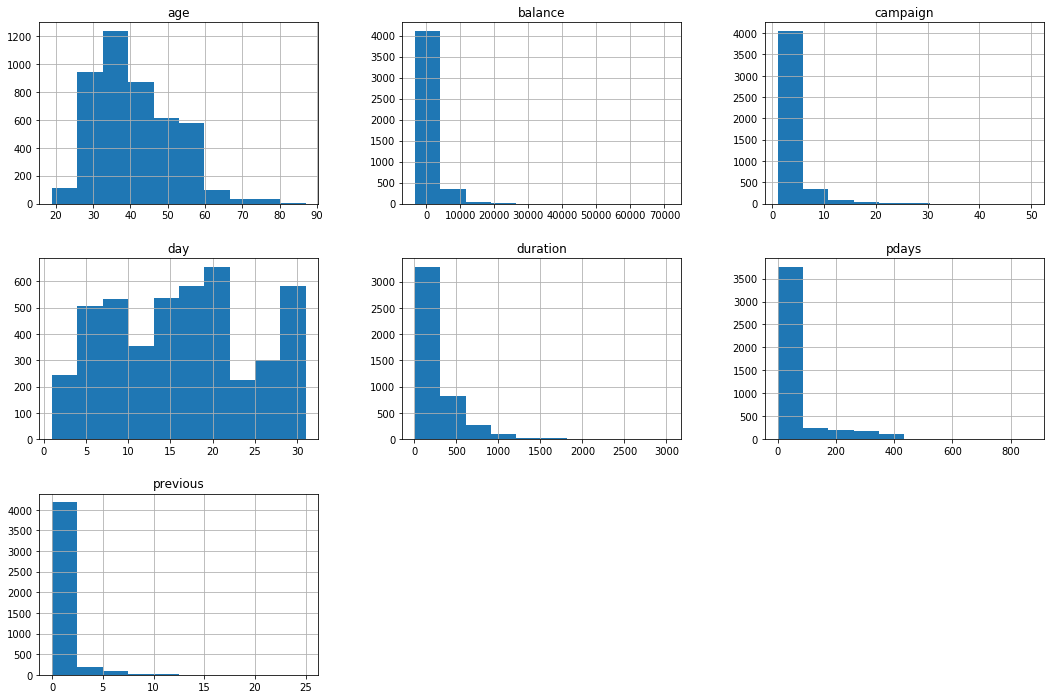

In [261]:
__ = Bankdata.hist(column=Bankdata.columns, figsize = (18,12))

#### Visualization of categorical columns of the dataset

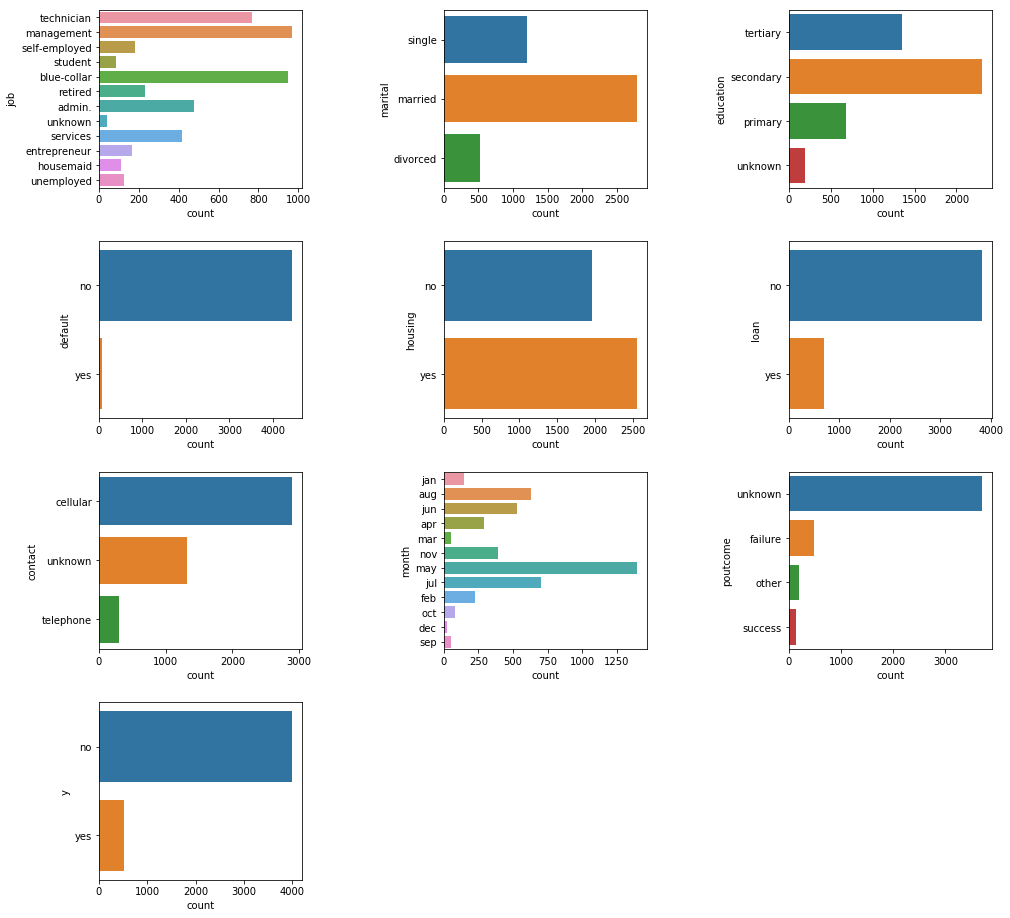

In [262]:
fig, axes = plt.subplots(4, 3, figsize=(16, 16))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.7, hspace=0.3)

for i, ax in enumerate(axes.ravel()):
    if i > 9:
        ax.set_visible(False)
        continue
    sns.countplot(y = Bankdata.describe(include=["object"]).columns[i], data=Bankdata, ax=ax)

#### Droping the unwanted columns from the dataset

In [59]:
Required_bankdata = Bankdata.drop(columns = ['day','month','housing','loan','duration'])
Required_bankdata = text_to_number(Required_bankdata,'y')
Required_bankdata.head()

,age,job,marital,education,default,balance,contact,campaign,pdays,previous,poutcome,y
2507,42,unemployed,single,secondary,no,2613,cellular,6,-1,0,unknown,0
1022,31,blue-collar,married,secondary,no,1243,unknown,1,-1,0,unknown,0
516,34,technician,married,tertiary,no,691,unknown,1,-1,0,unknown,0
2215,34,management,single,unknown,no,1534,cellular,1,147,7,other,0
3254,40,admin.,married,secondary,no,1327,unknown,2,-1,0,unknown,0


#### Check for Na and null values within the dataset and create dummies

In [60]:
Bankdata_dummies = check_na_null(Required_bankdata)
Bankdata_dummies.head()

,age,balance,campaign,pdays,previous,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,...,education_unknown,default_no,default_yes,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
2507,42,2613,6,-1,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1
1022,31,1243,1,-1,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,1
516,34,691,1,-1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
2215,34,1534,1,147,7,0,0,0,0,0,...,1,1,0,1,0,0,0,1,0,0
3254,40,1327,2,-1,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,0,1


#### Create Train and test dataset

In [61]:
Y_data = np.array(Bankdata_dummies.y)
Bankdata_dummies = Bankdata_dummies.drop(columns = 'y')
X_data = np.array(Bankdata_dummies)
Y_train,Y_test,X_train,X_test = create_Test_Train_data(X_data,Y_data)

print("Xtrain: " ,X_train.shape)
print("Ytrain: " ,Y_train.shape)
print("Xtest: " ,X_test.shape)
print("Ytest: " ,Y_test.shape)

Xtrain:  (3617, 33)
Ytrain:  (3617,)
Xtest:  (904, 33)
Ytest:  (904,)


#### Calling Logistic regression using Gradient descent function

β:  [-8.97545547e-06 -3.61941444e-04 -4.16479051e-04 -8.88951297e-04
 -2.78447677e-05 -2.22754007e-04 -2.16653068e-06 -9.57416973e-07
 -2.34774594e-06 -3.74415481e-07 -2.02049427e-07 -1.54804114e-06
 -2.18457536e-07 -3.82578242e-07 -9.29094832e-07 -7.19702120e-08
 -1.58225822e-06 -3.05960888e-07 -5.54665796e-08 -9.91402082e-07
 -6.01696460e-06 -1.96708880e-06 -1.44410013e-06 -5.04322387e-06
 -2.11173127e-06 -3.76400213e-07 -8.75731261e-06 -2.18142867e-07
 -4.99233207e-06 -4.74286551e-07 -3.50883685e-06 -8.74058068e-07
 -2.16990223e-07  2.97836787e-07 -8.18224397e-06]

Logloss: 0.554900151391623


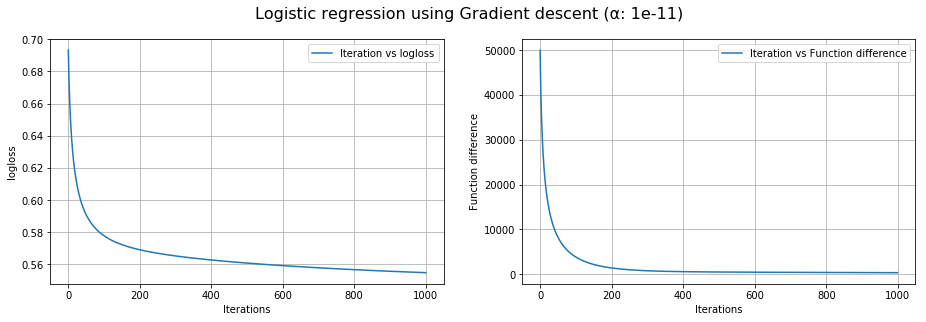

In [35]:
alpha = 1e-11
logreg_gd(Y_train,Y_test,X_train,X_test,alpha)

#### Calling Logistic regression using Stochastic Gradient Descent function 

β:  [-1.41840276e-05 -5.71177970e-04 -5.48258048e-04 -4.44373964e-05
 -3.53001076e-04 -3.71983202e-06 -1.51705514e-06 -3.67678146e-06
 -5.60310307e-07 -3.18738859e-07 -2.49831517e-06 -3.13015419e-07
 -5.77028778e-07 -1.49257513e-06 -1.33753124e-07 -2.54693507e-06
 -4.60814261e-07 -8.87048524e-08 -1.53748836e-06 -9.49058457e-06
 -3.15595465e-06 -2.19833217e-06 -7.94415749e-06 -3.46460808e-06
 -5.76929829e-07 -1.38507139e-05 -3.33313676e-07 -8.09396292e-06
 -7.93008870e-07 -5.29705579e-06 -1.28666151e-06 -4.19447715e-07
  4.59809346e-07 -1.29377277e-05]

Logloss: 0.589407706463278


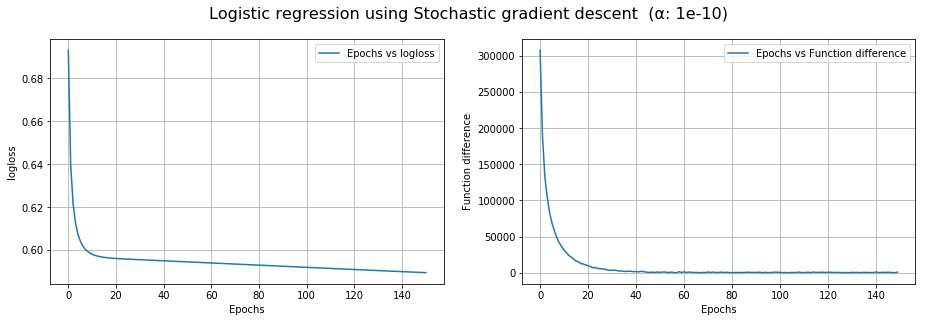

In [67]:
alpha = 1e-10
logreg_sgd(Y_train,Y_test,X_train,X_test,alpha)

#### Calling Logistic Regression using SGD with Bold driver step length controller 

β:  [-1.62237303e-04 -6.47327294e-03 -4.04754868e-04 -5.20158071e-04
 -2.11374419e-03 -2.00437232e-05 -1.70818979e-05 -4.27788703e-05
 -6.53294919e-06 -3.56958009e-06 -2.74708815e-05 -2.75061061e-06
 -6.91365484e-06 -1.77248975e-05 -1.63324562e-06 -2.94701570e-05
 -5.37798645e-06 -9.32571657e-07 -1.70827415e-05 -1.09128695e-04
 -3.60258663e-05 -2.48869029e-05 -9.21492411e-05 -3.85101357e-05
 -6.69102292e-06 -1.58182329e-04 -4.05497360e-06 -8.87880583e-05
 -8.81693960e-06 -6.46323048e-05 -1.07418735e-05 -3.39070694e-06
  7.46121708e-06 -1.55565939e-04]

Logloss: 0.5312012305941279


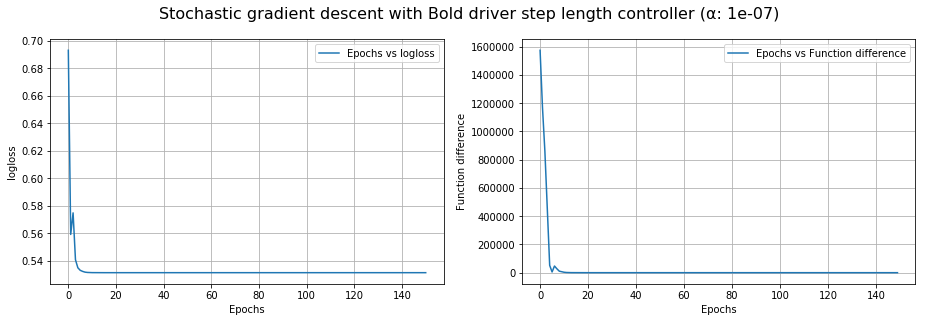

In [68]:
alpha = 1e-7
sgd_bold(Y_train,Y_test,X_train,X_test,alpha)

#### Calling Logistic Regression using SGD with Adagrad step length controller 

β:  [-8.76154564e-02 -3.23481361e-02  2.13647465e-05 -8.48501535e-02
  9.68757037e-04  4.05933409e-02 -2.75890673e-02 -1.33415565e-01
 -3.10174611e-02  1.19308874e-02  2.08474373e-03  1.05858802e-01
 -3.05846311e-02 -7.78637681e-02  1.11122538e-03 -6.13711882e-02
 -4.23626913e-02  8.59412159e-03  4.01744779e-02 -1.12712851e-01
 -3.75614338e-02 -1.32592741e-02 -1.04889750e-01 -8.28892435e-03
 -2.56570507e-02 -8.89536785e-02  2.69864546e-03 -3.85647965e-03
  2.10264256e-02 -2.24955857e-01 -5.78348287e-02 -3.39685349e-03
  1.62653121e-01 -1.45081701e-01]

Logloss: 0.3556536482051492


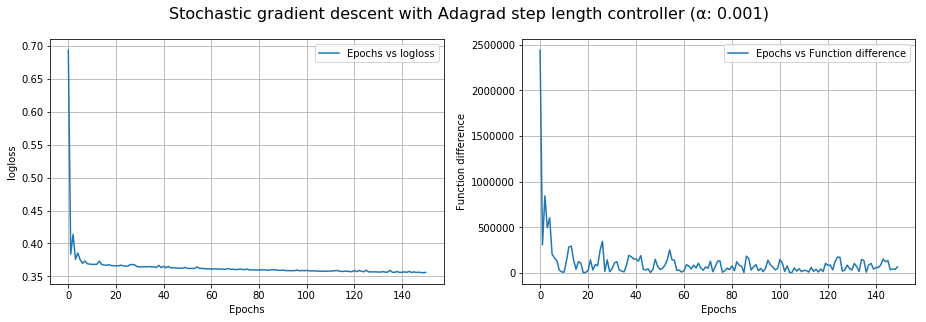

In [69]:
alpha = 1e-3
sgd_adagrad(Y_train,Y_test,X_train,X_test,alpha)

## Occupancy dataset

In [81]:
filename = "./Dataset/occupancy_data/datatraining.txt"
columns = None
Occupancydata = read_data(filename,columns,',')
Occupancydata = Occupancydata.sample(frac = 1)
Occupancydata.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
138,2015-02-04 20:08:00,21.76,27.100,0.0,530.0,0.004366,0
1253,2015-02-05 14:43:00,22.29,28.390,515.0,1020.0,0.004727,1
1495,2015-02-05 18:45:00,21.29,21.945,0.0,650.0,0.003430,0
1075,2015-02-05 11:44:59,22.20,27.100,444.0,1126.5,0.004486,1
5935,2015-02-08 20:44:59,19.39,27.390,0.0,445.5,0.003809,0


To begin with the problem, first we’ve to find the correlation between the input variables and the target 'y'
     for better prediction of the target class. For this, we can use spearman's co-efficient which uses pearson's coeffiecent of ranked variables


In [82]:
Occupancydata_correlation = []
Correlation = pd.DataFrame(index=np.arange(0, 1), columns=Occupancydata.columns )

for column in Occupancydata:
    if column != "Occupancy":
        Correlation[column] = (str(round(spearman_rank_coefficient(np.array(Occupancydata[column]),np.array(Occupancydata["Occupancy"])),4)))

Correlation

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,-0.0982,0.5328,0.1292,0.8046,0.6567,0.2558,NaN


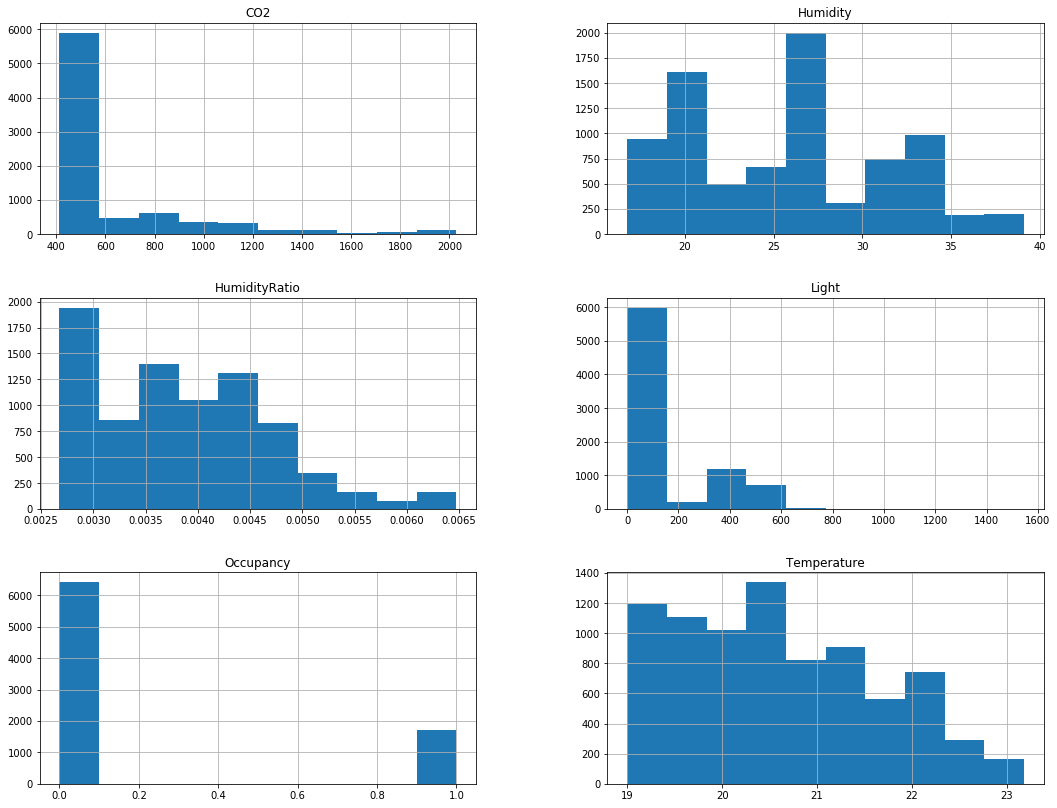

In [76]:
Occupancydata.hist(column=Occupancydata.columns, figsize = (18,14))
plt.show()

In [83]:
Required_Occupancydata = Occupancydata.drop(columns = ['date'])
Required_Occupancydata.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
138,21.76,27.100,0.0,530.0,0.004366,0
1253,22.29,28.390,515.0,1020.0,0.004727,1
1495,21.29,21.945,0.0,650.0,0.003430,0
1075,22.20,27.100,444.0,1126.5,0.004486,1
5935,19.39,27.390,0.0,445.5,0.003809,0


In [84]:
Y_data = np.array(Required_Occupancydata.Occupancy)
Required_Occupancydata = Required_Occupancydata.drop(columns = 'Occupancy')
X_data = np.array(Required_Occupancydata)
Y_train,Y_test,X_train,X_test = create_Test_Train_data(X_data,Y_data)

print("Xtrain: " ,X_train.shape)
print("Ytrain: " ,Y_train.shape)
print("Xtest: " ,X_test.shape)
print("Ytest: " ,Y_test.shape)

Xtrain:  (6515, 5)
Ytrain:  (6515,)
Xtest:  (1628, 5)
Ytest:  (1628,)


β:  [-5.67655640e-04 -1.15249734e-02 -1.07852252e-02  1.52783369e-02
 -4.07867697e-03 -1.51899130e-06]

Logloss: 0.29166367835235


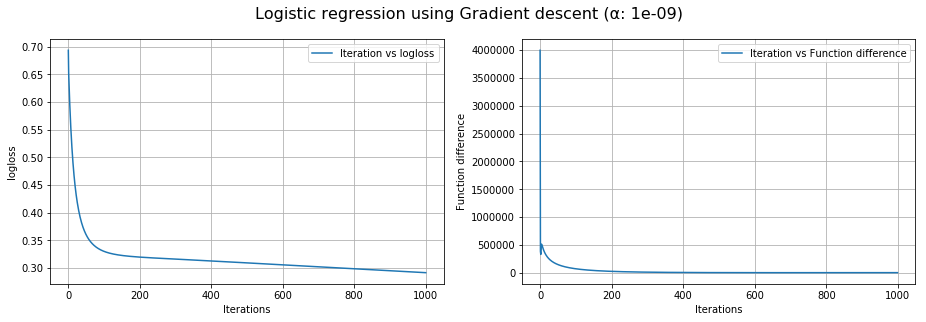

In [85]:
alpha = 1e-9

logreg_gd(Y_train,Y_test,X_train,X_test,alpha)

β:  [-1.16356841e-04 -2.31630602e-03 -2.42251697e-03  1.36454596e-02
 -4.17533110e-03 -3.35177951e-07]

Logloss: 0.32281981917907904


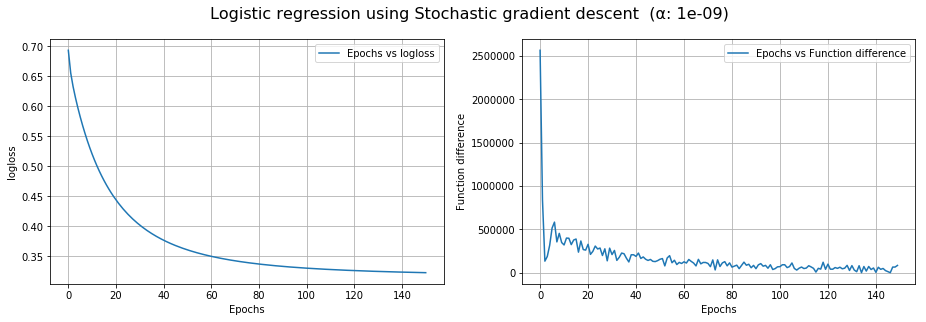

In [90]:
alpha = 1e-9
logreg_sgd(Y_train,Y_test,X_train,X_test,alpha)

β:  [-1.45633777e-04 -2.90956416e-03 -2.98339937e-03  1.45988147e-02
 -4.38584361e-03 -4.14015998e-07]

Logloss: 0.31976859094732324


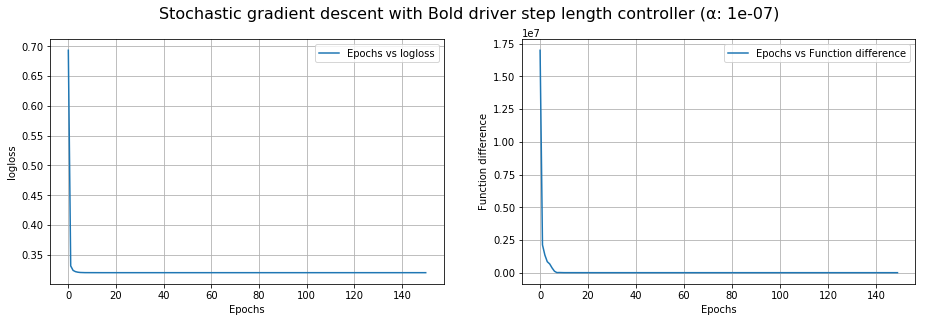

In [89]:
alpha = 1e-7
sgd_bold(Y_train,Y_test,X_train,X_test,alpha)

β:  [-0.2073459  -0.20263141 -0.11520504  0.01412297  0.00382223 -0.10921685]

Logloss: 0.08010139130503528


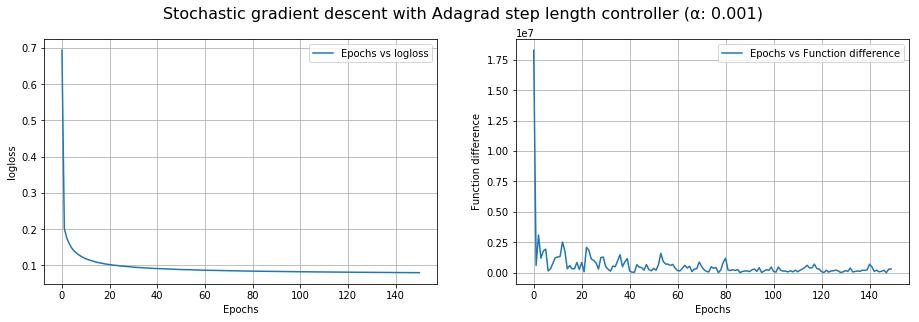

In [88]:
alpha = 1e-3
sgd_adagrad(Y_train,Y_test,X_train,X_test,alpha)